# 모델링을 통한 전세가 예측하기

In [1]:
# # 여기다가 install
# !pip install pandas
# !pip install matplotlib
# !pip install PublicDataReader --upgrade
# !pip install folium
# !pip install geopy
# !pip install reverse_geocode
# !pip install haversine
# !pip install openpyxl

In [2]:
# 필요한 패키지는 여기다가 쓰기(아래에 중복 X)
import pandas as pd
import numpy as np
import requests
import sys
import json
import datetime

# 시각화 패키지
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

# 지도시각화 패키지
import folium
from types import MethodWrapperType

# 거리계산 패키지
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import geopy.distance
import reverse_geocode
from scipy.spatial.distance import cdist
from haversine import haversine

## 1. 서울특별시 구별 상관관계 분석 및 시각화
## 2. 구 선정(성동구) 데이터 처리
## 3. 동별 모델링 진행

### open api 이용하여 서울특별시 전세가 불러오기

In [3]:
# open api 활용하기  (개인 키 쓰기!)
service_key = "vfY4VBbDDWnxBlsur1HG1qugKmYTCVY1e5g%2F8DvvKUsrqH2D%2FtDAqtT3VHoNq8zIXWmS5iFYfgGBBGBe5W%2FoOQ%3D%3D"
from PublicDataReader import TransactionPrice
api = TransactionPrice(service_key)

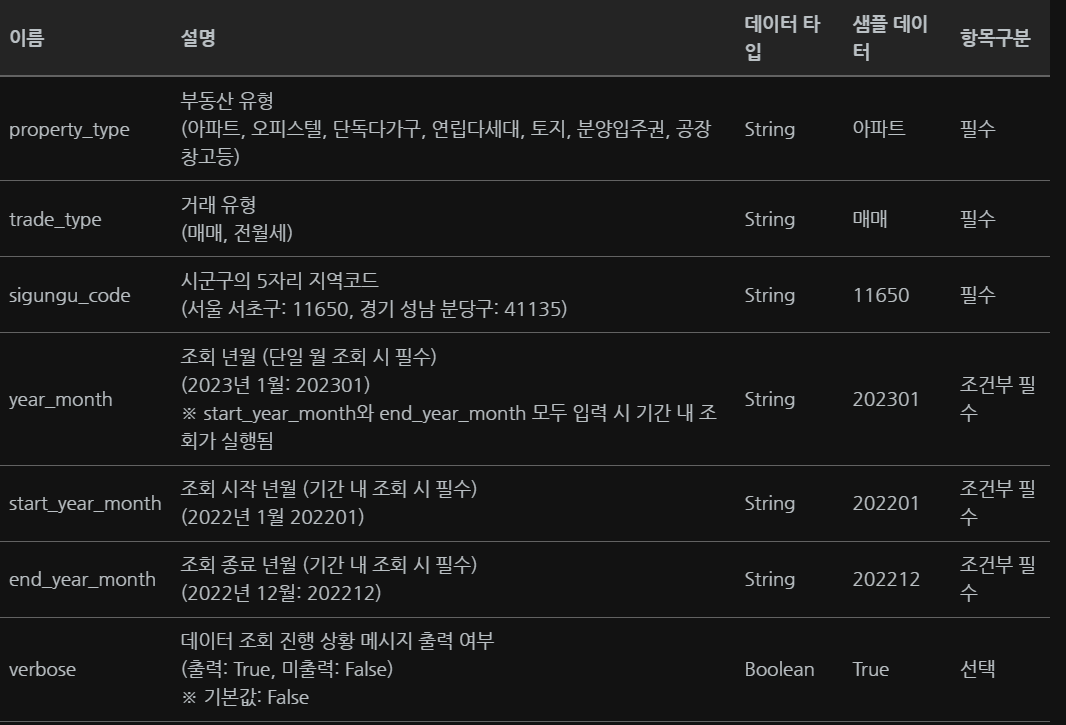

In [4]:
# 특정 년월 자료만 조회하기
# df = api.get_data(
#     property_type="연립다세대",
#     trade_type="전월세",
#     sigungu_code="11200",
#     start_year_month = "201501",
#     end_year_month = "202212"
#     )
# df.to_csv('seongdong.csv', encoding='euc-kr') 데이터 저장

## 서울시 관련된 Features 변수(범죄, 학생수, 생활만족도, 근로자)

In [5]:
# 범죄 데이터
crime = pd.read_csv('./data/crime.csv')
crime = crime.set_index('date')
# crime

# 학생 데이터
students = pd.read_csv('./data/students.csv', encoding='cp949')
students = students.set_index('date')
# students

# 만족도 데이터
life_satis = pd.read_csv('./data/life_satis.csv', encoding='cp949')
life_satis = life_satis.set_index('date')
# life_satis

# 근로자 데이터
workers = pd.read_csv('./data/workers.csv', encoding='cp949')
workers = workers.set_index('date')
# workers

### 시각화(꺾은선 그래프, 가로 막대 그래프)

<BarContainer object of 25 artists>

Text(0.5, 0, 'Correlation')

Text(0, 0.5, 'gu')

Text(0.5, 1.0, 'seoul corr')

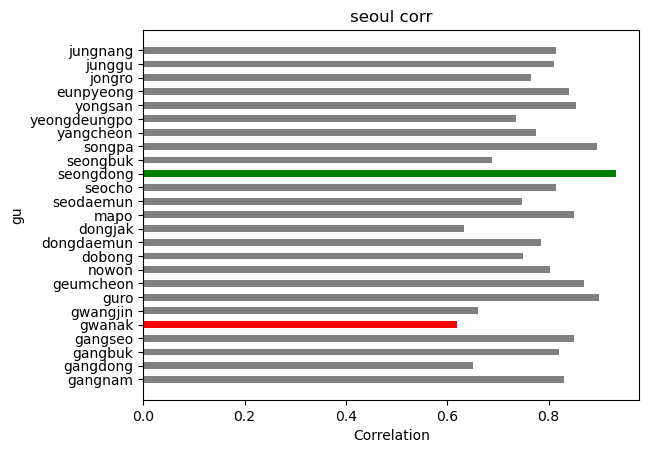

In [6]:
# 서울시 구별 상관관계 그래프
gu = ["gangnam", "gangdong", "gangbuk", "gangseo", "gwanak", "gwangjin", "guro", "geumcheon", "nowon", "dobong", "dongdaemun", "dongjak", "mapo",
      "seodaemun", "seocho", "seongdong", "seongbuk", "songpa", "yangcheon", "yeongdeungpo", "yongsan", "eunpyeong", "jongro", "junggu", "jungnang"]  # 구
Corr = [0.83, 0.65, 0.82, 0.85, 0.62, 0.66, 0.90, 0.87, 0.8025, 0.75, 0.785, 0.6325, 0.85, 0.7475, 0.815, 0.9325, 0.6875, 0.895, 0.775, 0.735, 0.855, 0.84, 0.765, 0.81, 0.815]  # 상관관계

# 가장 큰값과 작은값 찾기
max_index = np.argmax(Corr)
min_index = np.argmin(Corr)

# Create a list of colors with the same color for all bars
colors = ['gray'] * len(gu)

# 가장 큰 수와 작은수의 색 지정
colors[max_index] = 'green'
colors[min_index] = 'red'

plt.barh(gu, Corr, color=colors, height=0.5)  # Fix the color assignment
plt.xlabel('Correlation')  # x 라벨
plt.ylabel('gu')  # y 라벨
plt.title("seoul corr")  # 그래프 이름
# plt.grid(True, color='black', alpha=0.1)  # 그리드

plt.show()

(2013.0, 2024.0)

(700000.0, 1200000.0)

Text(0.5, 0, 'Year')

Text(0, 0.5, 'students')

Text(0.5, 1.0, 'seoul students')

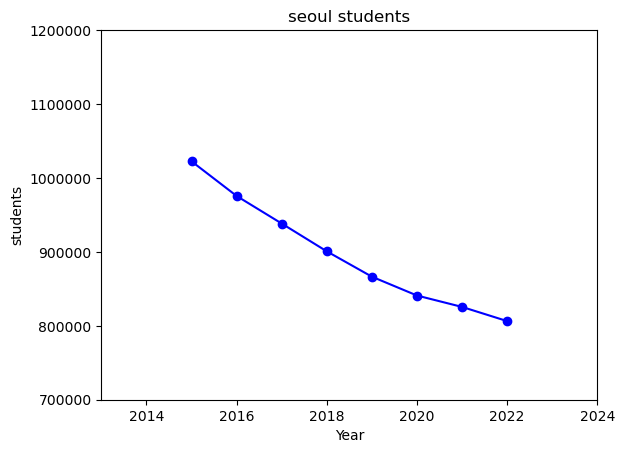

In [7]:
# 서울시 학생수 평균(2015~2022)

# 데이터 생성
df = pd.DataFrame({'X': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
                    'students': [1022447,975589,938302,900684,866395,840933,825503,806340]})

# 그래프 생성
plt.plot(df['X'], df['students'], color='blue', linestyle='-', marker='o', label='students')

# 그래프 정보 설정
plt.xlim(2013, 2024)  # x축 범위
plt.ylim(700000, 1200000)  # y축 범위
plt.ticklabel_format(axis= 'y' ,useOffset=False, style='plain') # y축 단위
plt.xlabel('Year')  # x 라벨
plt.ylabel('students')  # y 라벨
plt.title("seoul students")  # 그래프 이름

plt.show()

(2013.0, 2024.0)

(3000000.0, 6000000.0)

Text(0.5, 0, 'Year')

Text(0, 0.5, 'workers')

Text(0.5, 1.0, 'seoul workers')

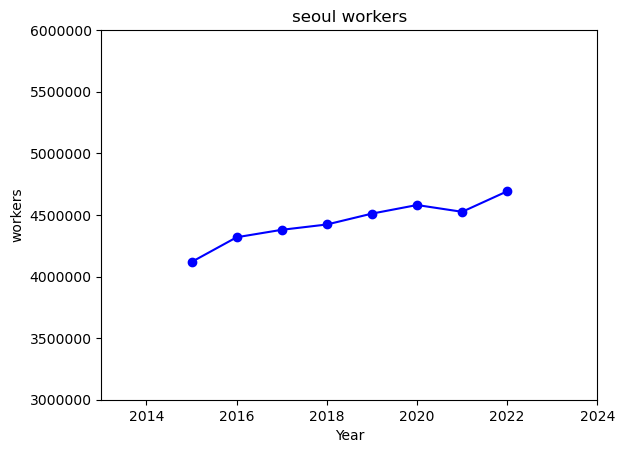

In [8]:
# 서울시 노동자수 평균(2015~2022)

# 데이터 생성
df = pd.DataFrame({'X': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
                    'workers': [4118232,4318700,4379207,4422311,4510651,4580334,4525270,4691985]})

# 그래프 생성
plt.plot(df['X'], df['workers'], color='blue', linestyle='-', marker='o', label='workers')

# 그래프 정보 설정
plt.xlim(2013, 2024)  # x축 범위
plt.ylim(3000000, 6000000)  # y축 범위
plt.ticklabel_format(axis= 'y' ,useOffset=False, style='plain') # y축 단위
plt.xlabel('Year')  # x 라벨
plt.ylabel('workers')  # y 라벨
plt.title("seoul workers")  # 그래프 이름

plt.show()

(2013.0, 2024.0)

(30000.0, 150000.0)

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Event')

Text(0.5, 1.0, 'seoul crimes')

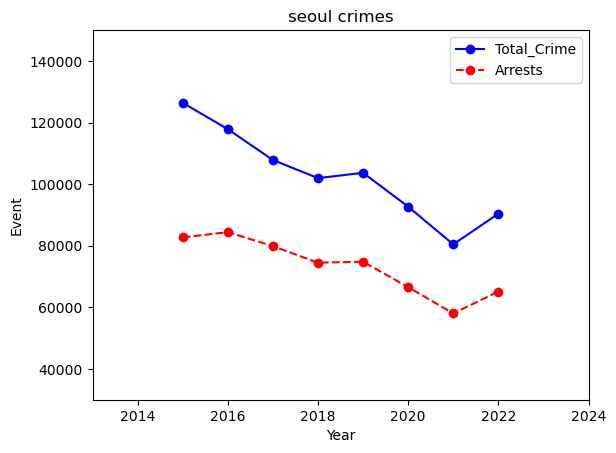

In [9]:
# 서울시 범죄수 평균(2015~2022)

# 데이터 생성
df1 = pd.DataFrame({'X': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
                    'Total_Crime': [126401, 117839, 107835, 101948, 103668, 92679, 80445, 90399]})
df2 = pd.DataFrame({'X': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
                    'arrest': [82680, 84421, 79865, 74487, 74805, 66548, 58012, 65097]})

# 그래프 생성
plt.plot(df1['X'], df1['Total_Crime'], color='blue', linestyle='-', marker='o', label='Total_Crime')
plt.plot(df2['X'], df2['arrest'], color='red', linestyle='--', marker='o', label='Arrests')

# 그래프 정보 설정
plt.xlim(2013, 2024)  # x축 범위
plt.ylim(30000, 150000)  # y축 범위
plt.xlabel('Year')  # x 라벨
plt.ylabel('Event')  # y 라벨
plt.title("seoul crimes")  # 그래프 이름

# 범례 추가
plt.legend()

# 그래프 출력
plt.show()

(2013.0, 2024.0)

(4.0, 8.0)

Text(0.5, 0, 'Year')

Text(0, 0.5, 'satisfaction')

Text(0.5, 1.0, 'seoul_life_satis')

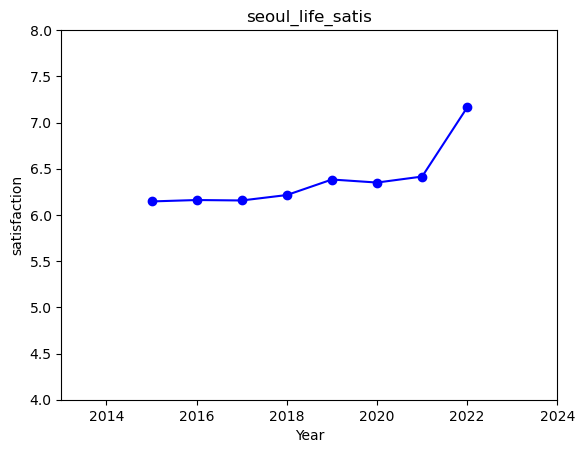

In [10]:
# 서울시 생활만족도 평균(2015~2022)

# 데이터 생성
df = pd.DataFrame({'X': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
                    'satisfaction': [6.146, 6.1612, 6.1564, 6.2152, 6.3832, 6.3504, 6.4152, 7.164]})

# 그래프 생성
plt.plot(df['X'], df['satisfaction'], color='blue', linestyle='-', marker='o', label='satisfaction')

# 그래프 정보 설정
plt.xlim(2013, 2024)  # x축 범위
plt.ylim(4, 8)  # y축 범위
plt.ticklabel_format(axis= 'y' ,useOffset=False, style='plain')
plt.xlabel('Year')  # x 라벨
plt.ylabel('satisfaction')  # y 라벨
plt.title("seoul_life_satis")  # 그래프 이름

plt.show()

### 지도시각화

In [11]:
# 각 컬럼별 평균 계산
crime_means = crime.mean()
students_means = students.mean()
life_satis_means = life_satis.mean()
workers_means = workers.mean()

# 구 경도 위도 데이터프레임 만들기
data = {
    '구': ['종로', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구','도봉구','노원구','은평구','서대문구','마포구','양천구', '강서구','구로구', '금천구', '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구'],
    '위도': [37.59491732, 37.56014356, 37.53138497, 37.55102969, 37.54670608, 37.58195655, 37.59780259, 37.6057019, 37.64347391, 37.66910208, 37.65251105, 37.61921128, 37.57778531, 37.55931349, 37.52478941, 37.56123543, 37.49440543, 37.46056756, 37.52230829, 37.49887688, 37.46737569, 37.47329547, 37.4966438, 37.50561924, 37.55045024],
    '경도': [126.9773213, 126.9959681, 126.97990, 127.0410585, 127.0857435, 127.0548481, 127.0928803, 127.0175795, 127.011189, 127.0323688, 127.0750347, 126.9270229, 126.9390631, 126.90827, 126.8554777, 126.822807, 126.8563006, 126.9008202, 126.9101695, 126.9516415, 126.9453372, 127.031220, 127.06298523, 127.115295, 127.1470118],
}

seoul_centers = pd.DataFrame(data)

In [12]:
# crime 지도 시각화
geo_json = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'


crime_m = folium.Map(
    location = [37.566345, 126.977893], zoom_start = 10.5, tiles = 'cartodbpositron', width="70%", height="70%"
)

folium.Choropleth(
    geo_data = geo_json,
    name = 'choropleth',
    data = crime_means,
    columns = ['name','value'],
    key_on = 'feature.properties.name',
    # geo json 색깔 설정
    fill_color='RdPu',
    # 지도 투명하게
    fill_opacity=0.7,
    # 경계선 투명하게
    line_opacity=1,
    # 경계선 굵기
    line_weight=1.5,
    # 경계선 색
    line_color='#000',
    # 범례 이름
    legend_name='범죄수',
).add_to(crime_m)

for index, row in seoul_centers.iterrows():
    html_text = f'<p style="writing-mode: vertical-lr; font-size: 7pt; text-align: center;">{row["구"]}</p>'  # 텍스트 스타일 추가
    folium.Marker(
        location=[row['위도'], row['경도']],
        icon=folium.DivIcon(html=html_text),
    ).add_to(crime_m)

crime_m

In [13]:
# students 학생 지도 시각화
geo_json = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'


students_m = folium.Map(
    location = [37.566345, 126.977893], zoom_start = 10.5, tiles = 'cartodbpositron', width="70%", height="70%"
)

folium.Choropleth(
    geo_data = geo_json,
    name = 'choropleth',
    data = students_means,
    columns = ['name','value'],
    key_on = 'feature.properties.name',
    # geo json 색깔 설정
    fill_color='YlOrBr',
    # 지도 투명하게
    fill_opacity=0.7,
    # 경계선 투명하게
    line_opacity=1,
    # 경계선 굵기
    line_weight=1.5,
    # 경계선 색
    line_color='#000',
    # 범례 이름
    legend_name='학생수',
).add_to(students_m)



for index, row in seoul_centers.iterrows():
    html_text = f'<p style="writing-mode: vertical-lr; font-size: 7pt; text-align: center;">{row["구"]}</p>'  # 텍스트 스타일 추가
    folium.Marker(
        location=[row['위도'], row['경도']],
        icon=folium.DivIcon(html=html_text),
    ).add_to(students_m)

students_m

In [14]:
# life_satis 생활만족도 지도 시각화
geo_json = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'


life_satis_m = folium.Map(
    location = [37.566345, 126.977893], zoom_start = 10.5, tiles = 'cartodbpositron', width="70%", height="70%"
)

folium.Choropleth(
    geo_data = geo_json,
    name = 'choropleth',
    data = life_satis_means,
    columns = ['name','value'],
    key_on = 'feature.properties.name',
    # geo json 색깔 설정
    fill_color='YlGn',
    # 지도 투명하게
    fill_opacity=0.7,
    # 경계선 투명하게
    line_opacity=1,
    # 경계선 굵기
    line_weight=1.5,
    # 경계선 색
    line_color='#000',
    # 범례 이름
    legend_name='만족도',
).add_to(life_satis_m)

for index, row in seoul_centers.iterrows():
    html_text = f'<p style="writing-mode: vertical-lr; font-size: 7pt; text-align: center;">{row["구"]}</p>'  # 텍스트 스타일 추가
    folium.Marker(
        location=[row['위도'], row['경도']],
        icon=folium.DivIcon(html=html_text),
    ).add_to(life_satis_m)

life_satis_m

In [15]:
# workers 근로자 지도 시각화
geo_json = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'


workers_m = folium.Map(
    location = [37.566345, 126.977893], zoom_start = 10.5, tiles = 'cartodbpositron', width="70%", height="70%"
)

folium.Choropleth(
    geo_data = geo_json,
    name = 'choropleth',
    data = workers_means,
    columns = ['name','value'],
    key_on = 'feature.properties.name',
    # geo json 색깔 설정
    fill_color='YlGnBu',
    # 지도 투명하게
    fill_opacity=0.7,
    # 경계선 투명하게
    line_opacity=1,
    # 경계선 굵기
    line_weight=1.5,
    # 경계선 색
    line_color='#000',
    # 범례 이름
    legend_name='근로자수',
).add_to(workers_m)

for index, row in seoul_centers.iterrows():
    html_text = f'<p style="writing-mode: vertical-lr; font-size: 7pt; text-align: center;">{row["구"]}</p>'  # 텍스트 스타일 추가
    folium.Marker(
        location=[row['위도'], row['경도']],
        icon=folium.DivIcon(html=html_text),
    ).add_to(workers_m)

workers_m

## 변수들 간 상관관계가 가장 높은 성동구 선정

### 데이터 전처리

In [16]:
# 성동구 2015~2022년 데이터 불러오기
seongdong_df = pd.read_csv('./data/seoul/seongdong.csv', index_col = 0) 
seongdong_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12211 entries, 11200 to 11200
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   법정동      12211 non-null  object 
 1   지번       12211 non-null  object 
 2   연립다세대    12211 non-null  object 
 3   건축년도     12211 non-null  int64  
 4   층        12151 non-null  float64
 5   전용면적     12211 non-null  float64
 6   년        12211 non-null  int64  
 7   월        12211 non-null  int64  
 8   일        12211 non-null  int64  
 9   보증금액     12211 non-null  int64  
 10  월세금액     12211 non-null  int64  
 11  계약구분     2482 non-null   object 
 12  계약기간     2690 non-null   object 
 13  갱신요구권사용  330 non-null    object 
 14  종전계약보증금  699 non-null    float64
 15  종전계약월세   130 non-null    float64
dtypes: float64(4), int64(6), object(6)
memory usage: 1.6+ MB


In [17]:
# 필요한 features만 추출하기
seongdong_df = seongdong_df[['년', '월', '건축년도', '법정동', '지번', '층', '전용면적', '보증금액', '월세금액']]
seongdong_df.head()

,년,월,건축년도,법정동,지번,층,전용면적,보증금액,월세금액
지역코드,,,,,,,,,
11200,2015,1,1986,하왕십리동,890-401,3.0,39.70,15000,0
11200,2015,1,2012,하왕십리동,890-114,4.0,13.97,3000,30
11200,2015,1,1977,홍익동,125,3.0,85.36,17000,0
11200,2015,1,2014,홍익동,367,2.0,27.45,19000,0
11200,2015,1,2012,도선동,188,5.0,17.56,6000,30


In [18]:
# seongdong_df columns 값 변경하기
seongdong_df.rename(columns = {'년' : 'deal_y',
                               '월' : 'deal_m',
                               '건축년도' : 'build_year',
                               '법정동' : 'dong',
                               '지번' : 'jibun',
                               '층' : 'floor',
                               '전용면적' : 'use_area',
                               '보증금액' : 'deposit',
                               '월세금액' : 'm_rent'}, inplace = True)

seongdong_df.head()

,deal_y,deal_m,build_year,dong,jibun,floor,use_area,deposit,m_rent
지역코드,,,,,,,,,
11200,2015,1,1986,하왕십리동,890-401,3.0,39.70,15000,0
11200,2015,1,2012,하왕십리동,890-114,4.0,13.97,3000,30
11200,2015,1,1977,홍익동,125,3.0,85.36,17000,0
11200,2015,1,2014,홍익동,367,2.0,27.45,19000,0
11200,2015,1,2012,도선동,188,5.0,17.56,6000,30


In [19]:
# 년 월 합치기
seongdong_df['date'] = seongdong_df['deal_y'].astype(str) + seongdong_df['deal_m'].astype(str).str.zfill(2)

# 기존 date 컬럼 지우고 왼쪽으로 옮기기
date_column = seongdong_df.pop('date')
seongdong_df.insert(0, 'date', date_column)

seongdong_df.head()

,date,deal_y,deal_m,build_year,dong,jibun,floor,use_area,deposit,m_rent
지역코드,,,,,,,,,,
11200,201501,2015,1,1986,하왕십리동,890-401,3.0,39.70,15000,0
11200,201501,2015,1,2012,하왕십리동,890-114,4.0,13.97,3000,30
11200,201501,2015,1,1977,홍익동,125,3.0,85.36,17000,0
11200,201501,2015,1,2014,홍익동,367,2.0,27.45,19000,0
11200,201501,2015,1,2012,도선동,188,5.0,17.56,6000,30


In [20]:
# 월세 전세 보증금으로 전환하기

# 연도별 전세 전환율
conversion_rate ={
    2015: 6.3,
    2016: 5.6,
    2017: 5,
    2018: 4.7,
    2019: 4.5,
    2020: 4.1,
    2021: 4,
    2022: 4
}

# 월세 전세가로 변경
seongdong_df['total_deposit'] = 0
for year, rate in conversion_rate.items():
    tmp = (seongdong_df['deal_y'] == year)  
    seongdong_df.loc[tmp, 'total_deposit'] = seongdong_df.loc[tmp, 'deposit'] + (seongdong_df.loc[tmp, 'm_rent'] * 12 / (rate*0.01))

# 불필요한 열 제거
seongdong_df.drop(columns=['deal_y', 'deal_m', 'deposit', 'm_rent'], inplace=True)

seongdong_df.head()

,date,build_year,dong,jibun,floor,use_area,total_deposit
지역코드,,,,,,,
11200,201501,1986,하왕십리동,890-401,3.0,39.70,15000.000000
11200,201501,2012,하왕십리동,890-114,4.0,13.97,8714.285714
11200,201501,1977,홍익동,125,3.0,85.36,17000.000000
11200,201501,2014,홍익동,367,2.0,27.45,19000.000000
11200,201501,2012,도선동,188,5.0,17.56,11714.285714


In [21]:
# date 타입을 오브젝트로 변경해서 구했기 때문에 다시 int형태로 변환시켜준다
seongdong_df['date'] = seongdong_df['date'].astype('int64')

seongdong_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12211 entries, 11200 to 11200
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           12211 non-null  int64  
 1   build_year     12211 non-null  int64  
 2   dong           12211 non-null  object 
 3   jibun          12211 non-null  object 
 4   floor          12151 non-null  float64
 5   use_area       12211 non-null  float64
 6   total_deposit  12211 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 763.2+ KB


In [22]:
# floor(층)의 결측값이 60개 : 전처리 필요

seongdong_df.isnull().sum()

date              0
build_year        0
dong              0
jibun             0
floor            60
use_area          0
total_deposit     0
dtype: int64

In [23]:
# floor(층)의 결측값 0층으로 처리

seongdong_df['floor'] = seongdong_df['floor'].fillna(0)
seongdong_df.isnull().sum()

date             0
build_year       0
dong             0
jibun            0
floor            0
use_area         0
total_deposit    0
dtype: int64

In [24]:
# floor int형으로 변환
# total_deposit int형으로 변환
seongdong_df['floor'] = seongdong_df['floor'].astype('int64')
seongdong_df['total_deposit'] = seongdong_df['total_deposit'].astype('int64')
seongdong_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12211 entries, 11200 to 11200
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           12211 non-null  int64  
 1   build_year     12211 non-null  int64  
 2   dong           12211 non-null  object 
 3   jibun          12211 non-null  object 
 4   floor          12211 non-null  int64  
 5   use_area       12211 non-null  float64
 6   total_deposit  12211 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 763.2+ KB


In [25]:
# 최종 확인
seongdong_df.head(3)

,date,build_year,dong,jibun,floor,use_area,total_deposit
지역코드,,,,,,,
11200,201501,1986,하왕십리동,890-401,3,39.70,15000
11200,201501,2012,하왕십리동,890-114,4,13.97,8714
11200,201501,1977,홍익동,125,3,85.36,17000


In [26]:
seongdong_df.to_csv('./data/seongdong_df.csv')

## 필요한 변수 추가하기(지하철, 음식점, 교육시설, cctv)

### 동별 연도별 음식점 변수 전처리 후 추가

In [27]:
# 음식점 데이터 프레임 불러오기
restaurant_df = pd.read_csv('./data/seongdong_res.csv', encoding='cp949')
restaurant_df.head(2)

,업종명,인허가일자,업소명,도로명주소,영업장면적,업태명
0,일반음식점,2018-12-27,오후五厚,"서울특별시 성동구 서울숲2길 44-7, 1층 (성수동1가)",83.42,한식
1,일반음식점,2018-11-02,술있는 식탁,"서울특별시 성동구 왕십리로10길 18, 지층 (성수동1가)",47.52,기타


In [28]:
# 음식점 3931개의 데이터(도로명 주소만 사용)
restaurant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3931 entries, 0 to 3930
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   업종명     3931 non-null   object 
 1   인허가일자   3931 non-null   object 
 2   업소명     3931 non-null   object 
 3   도로명주소   3888 non-null   object 
 4   영업장면적   3925 non-null   float64
 5   업태명     3931 non-null   object 
dtypes: float64(1), object(5)
memory usage: 184.4+ KB


In [29]:
# 결측값 확인(도로명 주소에 43개 결측값 확인)
restaurant_df.isnull().sum()

업종명       0
인허가일자     0
업소명       0
도로명주소    43
영업장면적     6
업태명       0
dtype: int64

In [30]:
# 결측치가 있는 행 제거
restaurant_df = restaurant_df.dropna(subset=['도로명주소'])
restaurant_df.isnull().sum()

업종명      0
인허가일자    0
업소명      0
도로명주소    0
영업장면적    6
업태명      0
dtype: int64

In [31]:
# 동 추출하기

restaurant_df['동'] = restaurant_df['도로명주소'].str.extract(r'\(([^)]+)\)')
restaurant_df['동'] = restaurant_df['동'].str.split(',').str[0]
restaurant_df.tail()

,업종명,인허가일자,업소명,도로명주소,영업장면적,업태명,동
3926,일반음식점,2022-05-19,하우 엠(How M),"서울특별시 성동구 장터길 32, 2층 (금호동4가)",61.74,기타,금호동4가
3927,일반음식점,2022-04-28,완강정,"서울특별시 성동구 장터길 14, 1층 (금호동4가)",6.50,기타,금호동4가
3928,일반음식점,2022-05-17,잇프레쉬,"서울특별시 성동구 성수일로4길 33, 1층 (성수동2가)",8.00,기타,성수동2가
3929,일반음식점,2022-05-17,와인쌤마켓(WINE SSEM MARKET),"서울특별시 성동구 아차산로17길 48, 성수 SK V1 CENTER I 1층 R10...",139.06,기타,성수동2가
3930,일반음식점,2022-05-17,중앙해장포장 금호점,"서울특별시 성동구 금호로 15, 상가동 1층 102호 (금호동4가, 서울숲푸르지오아파트)",21.60,한식,금호동4가


In [32]:
# 동 이름 확인
restaurant_df.동.unique()

array(['성수동1가', '성수동2가', '상왕십리동', '금호동3가', '홍익동', '행당동', '도선동', '용답동',
       '마장동', '옥수동', '금호동2가', '금호동1가', '하왕십리동', '사근동', '금호동4가', '응봉동',
       '송정동', '주', '지식산업센터', '-1', 'C', 'B', 'HOTEL POCO', '나',
       'SPACE WANGSIMNI', '종합사회복지관상가', '가단지', '상가1동'], dtype=object)

### 음식점 전처리

In [33]:
# 동이 명확하게 안나오는 것들을 찾아서 전처리
restaurant_df[restaurant_df.동 == '주']
restaurant_df.loc[restaurant_df['동'] == '주', '동'] = '성수동2가'

restaurant_df[restaurant_df.동 == '지식산업센터']
restaurant_df.loc[restaurant_df['동'] == '지식산업센터', '동'] = '성수동1가'

restaurant_df[restaurant_df.동 == '-1']
restaurant_df.loc[restaurant_df['동'] == '-1', '동'] = '행당동'

restaurant_df[restaurant_df.동 == 'C']
restaurant_df.loc[restaurant_df['동'] == 'C', '동'] = '성수동2가'

restaurant_df[restaurant_df.동 == 'B']
restaurant_df.loc[restaurant_df['동'] == 'B', '동'] = '성수동2가'

restaurant_df[restaurant_df.동 == 'HOTEL POCO']
restaurant_df.loc[restaurant_df['동'] == 'HOTEL POCO', '동'] = '성수동2가'

restaurant_df[restaurant_df.동 == '나']
restaurant_df.loc[restaurant_df['동'] == '나', '동'] = '성수동2가'

restaurant_df[restaurant_df.동 == 'SPACE WANGSIMNI']
restaurant_df.loc[restaurant_df['동'] == 'SPACE WANGSIMNI', '동'] = '하왕십리동'

restaurant_df[restaurant_df.동 == '종합사회복지관상가']
restaurant_df.loc[restaurant_df['동'] == '종합사회복지관상가', '동'] = '금호동4가'

restaurant_df[restaurant_df.동 == '가단지']
restaurant_df.loc[restaurant_df['동'] == '가단지', '동'] = '성수동1가'

restaurant_df[restaurant_df.동 == '상가1동']
restaurant_df.loc[restaurant_df['동'] == '상가1동', '동'] = '행당동'

restaurant_df.동.unique()

,업종명,인허가일자,업소명,도로명주소,영업장면적,업태명,동
619,일반음식점,2018-01-16,교대이층집 성수점,"서울특별시 성동구 성수일로8길 60, 한일비지네스(주) 2층 (성수동2가)",246.00,식육(숯불구이),주
2473,일반음식점,2023-04-28,락사(LAXXA),서울특별시 성동구 성수이로14길 14 (주)대명케미칼 나(B)동 1층 102호 (성...,40.79,기타,주
2874,일반음식점,2018-08-23,풍조미역,"서울특별시 성동구 성수일로8길 60, 한일비지네스(주) 1층 (성수동2가)",141.88,한식,주
3691,일반음식점,2021-06-30,메이플탑,서울특별시 성동구 성수이로14길 14 (주)대명케미칼 나동 2층 (성수동2가),133.66,경양식,주
3720,일반음식점,2018-12-10,자파브루어리(JAFA Brewery),서울특별시 성동구 성수이로14길 14 (주)대명케미칼 가동 1층 (성수동2가),161.07,경양식,주
3866,일반음식점,2022-06-07,하우스바이,"서울특별시 성동구 아차산로5길 24-33, 신한서브(주) 1층 (성수동2가)",13.20,기타,주


,업종명,인허가일자,업소명,도로명주소,영업장면적,업태명,동
710,일반음식점,2017-12-08,(주) 밥플러스 메타모르포점,"서울특별시 성동구 성수일로 89, Metamorpho(지식산업센터) 1층 103,1...",192.00,한식,지식산업센터
3220,일반음식점,2021-05-26,신의주찹쌀순대&쭈꾸미,"서울특별시 성동구 성수일로 89, Metamorpho(지식산업센터) 1층 102호 ...",89.86,한식,지식산업센터


,업종명,인허가일자,업소명,도로명주소,영업장면적,업태명,동
1497,일반음식점,2012-11-23,쏘러스(Saurros),"서울특별시 성동구 마조로 21, 지상1층 2(-1)호 (행당동, 19-9)",13.0,경양식,-1


,업종명,인허가일자,업소명,도로명주소,영업장면적,업태명,동
2211,일반음식점,2019-11-28,카페 RSG,"서울특별시 성동구 연무장15길 11, 가(C)동 1층 C109호, C110호 (성수...",45.85,기타,C
2792,일반음식점,2023-03-31,옥자 성수,"서울특별시 성동구 연무장15길 11, 태광산업 가(C)동 2층 C202호 (성수동2가)",96.36,기타,C


,업종명,인허가일자,업소명,도로명주소,영업장면적,업태명,동
2748,일반음식점,2021-11-23,(주)위프라이(WeFry),"서울특별시 성동구 연무장15길 11, 태광산업 가(B)동 1층 102호 (성수동2가)",24.00,기타,B
3455,일반음식점,2022-09-15,컨셉비(Concept B),"서울특별시 성동구 연무장15길 11, 태광산업 가(B)동 1층 B101-A호 (성수...",23.10,기타,B
3862,일반음식점,2022-06-29,쁘띠 다이너(Petit Diner),"서울특별시 성동구 연무장15길 11, 태광산업 가(B)동 1층 B124, B125,...",87.12,경양식,B


,업종명,인허가일자,업소명,도로명주소,영업장면적,업태명,동
2840,일반음식점,2023-03-29,노비아 에 노비오,"서울특별시 성동구 성수이로 96, 호텔포코(HOTEL POCO) 2층 (성수동2가)",209.07,경양식,HOTEL POCO


,업종명,인허가일자,업소명,도로명주소,영업장면적,업태명,동
2944,일반음식점,2020-08-24,이키나리 돈부리,"서울특별시 성동구 아차산로7길 36, 1층 1-1(나)호 (성수동2가)",50.76,일식,나


,업종명,인허가일자,업소명,도로명주소,영업장면적,업태명,동
3128,일반음식점,2023-01-26,만만스시,"서울특별시 성동구 왕십리로 382, 스페이스 왕십리(SPACE WANGSIMNI) ...",123.92,일식,SPACE WANGSIMNI


,업종명,인허가일자,업소명,도로명주소,영업장면적,업태명,동
3462,일반음식점,2022-09-22,반장즉석떡볶이 금호점,"서울특별시 성동구 행당로6길 2, 벽산아파트(종합사회복지관상가) 1층 104호 (금...",13.53,한식,종합사회복지관상가


,업종명,인허가일자,업소명,도로명주소,영업장면적,업태명,동
3661,일반음식점,2022-07-12,에보,"서울특별시 성동구 상원길 80, 성수동동아그린아파트 상가(가단지)동 1층 101호 ...",29.0,경양식,가단지


,업종명,인허가일자,업소명,도로명주소,영업장면적,업태명,동
3850,일반음식점,2022-05-24,엄마네 꼬꼬,"서울특별시 성동구 고산자로2길 67, 서울숲리버뷰자이(상가1동) 상가1동 1층 11...",48.65,기타,상가1동


array(['성수동1가', '성수동2가', '상왕십리동', '금호동3가', '홍익동', '행당동', '도선동', '용답동',
       '마장동', '옥수동', '금호동2가', '금호동1가', '하왕십리동', '사근동', '금호동4가', '응봉동',
       '송정동'], dtype=object)

In [34]:
restaurant_df.head()

,업종명,인허가일자,업소명,도로명주소,영업장면적,업태명,동
0,일반음식점,2018-12-27,오후五厚,"서울특별시 성동구 서울숲2길 44-7, 1층 (성수동1가)",83.42,한식,성수동1가
1,일반음식점,2018-11-02,술있는 식탁,"서울특별시 성동구 왕십리로10길 18, 지층 (성수동1가)",47.52,기타,성수동1가
2,일반음식점,2018-11-29,앳모스피어(atmosphere),"서울특별시 성동구 아차산로17길 11, 1층 (성수동2가)",50.87,경양식,성수동2가
3,일반음식점,2018-12-04,더육회,"서울특별시 성동구 마장로 137, 221동 1층 1121호 (상왕십리동, 텐즈힐)",29.25,일식,상왕십리동
4,일반음식점,2018-11-02,큰집 빈대떡 포차,"서울특별시 성동구 장터길 35-1, 1층 (금호동3가)",23.00,한식,금호동3가


In [35]:
# 년월로 바꾸기
restaurant_df['인허가일자'] = pd.to_datetime(restaurant_df['인허가일자'])
restaurant_df['Year'] = pd.to_datetime(restaurant_df['인허가일자']).dt.strftime('%Y%m').astype(int)
restaurant_df.head()

,업종명,인허가일자,업소명,도로명주소,영업장면적,업태명,동,Year
0,일반음식점,2018-12-27,오후五厚,"서울특별시 성동구 서울숲2길 44-7, 1층 (성수동1가)",83.42,한식,성수동1가,201812
1,일반음식점,2018-11-02,술있는 식탁,"서울특별시 성동구 왕십리로10길 18, 지층 (성수동1가)",47.52,기타,성수동1가,201811
2,일반음식점,2018-11-29,앳모스피어(atmosphere),"서울특별시 성동구 아차산로17길 11, 1층 (성수동2가)",50.87,경양식,성수동2가,201811
3,일반음식점,2018-12-04,더육회,"서울특별시 성동구 마장로 137, 221동 1층 1121호 (상왕십리동, 텐즈힐)",29.25,일식,상왕십리동,201812
4,일반음식점,2018-11-02,큰집 빈대떡 포차,"서울특별시 성동구 장터길 35-1, 1층 (금호동3가)",23.00,한식,금호동3가,201811


In [36]:
# 1970년 7월부터 2023년 6월까지 자료
print(restaurant_df['Year'].min())
print(restaurant_df['Year'].max())

197007
202306


In [37]:
# 필요한 변수만 설정
subset_df = restaurant_df[['Year', '동']]
subset_df

,Year,동
0,201812,성수동1가
1,201811,성수동1가
2,201811,성수동2가
3,201812,상왕십리동
4,201811,금호동3가
...,...,...
3926,202205,금호동4가
3927,202204,금호동4가
3928,202205,성수동2가
3929,202205,성수동2가


In [38]:
# 인허가 날짜 == 2023?? 은 제거 
subset_df = restaurant_df[subset_df['Year'] <= 202212]
subset_df

,업종명,인허가일자,업소명,도로명주소,영업장면적,업태명,동,Year
0,일반음식점,2018-12-27,오후五厚,"서울특별시 성동구 서울숲2길 44-7, 1층 (성수동1가)",83.42,한식,성수동1가,201812
1,일반음식점,2018-11-02,술있는 식탁,"서울특별시 성동구 왕십리로10길 18, 지층 (성수동1가)",47.52,기타,성수동1가,201811
2,일반음식점,2018-11-29,앳모스피어(atmosphere),"서울특별시 성동구 아차산로17길 11, 1층 (성수동2가)",50.87,경양식,성수동2가,201811
3,일반음식점,2018-12-04,더육회,"서울특별시 성동구 마장로 137, 221동 1층 1121호 (상왕십리동, 텐즈힐)",29.25,일식,상왕십리동,201812
4,일반음식점,2018-11-02,큰집 빈대떡 포차,"서울특별시 성동구 장터길 35-1, 1층 (금호동3가)",23.00,한식,금호동3가,201811
...,...,...,...,...,...,...,...,...
3926,일반음식점,2022-05-19,하우 엠(How M),"서울특별시 성동구 장터길 32, 2층 (금호동4가)",61.74,기타,금호동4가,202205
3927,일반음식점,2022-04-28,완강정,"서울특별시 성동구 장터길 14, 1층 (금호동4가)",6.50,기타,금호동4가,202204
3928,일반음식점,2022-05-17,잇프레쉬,"서울특별시 성동구 성수일로4길 33, 1층 (성수동2가)",8.00,기타,성수동2가,202205
3929,일반음식점,2022-05-17,와인쌤마켓(WINE SSEM MARKET),"서울특별시 성동구 아차산로17길 48, 성수 SK V1 CENTER I 1층 R10...",139.06,기타,성수동2가,202205


In [39]:
year_range = range(1970, 2023)
month_range = range(1,13)
columns = subset_df['동'].unique()
index = []
for year in year_range:
    for month in month_range:
        index.append(year*100 + month)
result_df = pd.DataFrame(index=index, columns=columns).fillna(0)

result_df

,성수동1가,성수동2가,상왕십리동,금호동3가,홍익동,행당동,도선동,용답동,마장동,옥수동,금호동2가,금호동1가,하왕십리동,사근동,금호동4가,응봉동,송정동
197001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
197002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
197003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
197004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
197005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202208,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
202209,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
202210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
202211,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
for index, row in subset_df.iterrows():
    current_year = row['Year']
    current_dong = row['동']
    
    
    result_df.loc[current_year:202212, current_dong] += 1

result_df.tail()

,성수동1가,성수동2가,상왕십리동,금호동3가,홍익동,행당동,도선동,용답동,마장동,옥수동,금호동2가,금호동1가,하왕십리동,사근동,금호동4가,응봉동,송정동
202208,655,910,47,103,92,548,138,168,150,120,78,55,160,38,91,23,66
202209,664,925,48,107,92,552,138,170,151,121,78,56,161,40,92,23,66
202210,676,933,48,108,92,556,138,171,153,122,79,56,163,40,93,23,66
202211,692,946,48,108,92,563,138,172,155,123,79,57,164,40,95,23,69
202212,708,958,51,108,92,566,139,173,155,124,81,58,166,40,96,23,70


In [41]:
result_df = result_df.loc[201501:202212]

result_df

,성수동1가,성수동2가,상왕십리동,금호동3가,홍익동,행당동,도선동,용답동,마장동,옥수동,금호동2가,금호동1가,하왕십리동,사근동,금호동4가,응봉동,송정동
201501,168,326,10,50,51,300,75,103,97,50,35,21,36,17,40,15,30
201502,168,328,10,50,53,300,76,103,97,50,35,21,36,17,40,15,31
201503,168,330,11,51,53,302,76,104,97,50,35,21,37,17,44,15,31
201504,168,333,11,52,53,305,76,104,97,50,35,21,38,17,45,15,31
201505,170,336,11,52,53,305,76,104,98,51,35,22,39,17,45,15,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202208,655,910,47,103,92,548,138,168,150,120,78,55,160,38,91,23,66
202209,664,925,48,107,92,552,138,170,151,121,78,56,161,40,92,23,66
202210,676,933,48,108,92,556,138,171,153,122,79,56,163,40,93,23,66
202211,692,946,48,108,92,563,138,172,155,123,79,57,164,40,95,23,69


In [42]:
# 음식점 월별 개수 데이터 저장
result_df.to_csv('./data/restaurant.csv', encoding='utf-8-sig')

## 학교 데이터 전처리

In [43]:
# 성동구 데이터 불러오기
# df1 = 성동구 동 좌표, df2 = 성동구 학교 좌표
school_df1 = pd.read_csv("./data/dong.csv", encoding = "cp949")
school_df2 = pd.read_csv("./data/school_location.csv", encoding = "cp949")

In [44]:
# 위도 경도 이름 변경
school_df1 = school_df1.rename(columns={'위도':'dong_lat'})
school_df1 = school_df1.rename(columns={'경도':'dong_long'})

school_df2 = school_df2.rename(columns={'위도':'school_lat'})
school_df2 = school_df2.rename(columns={'경도':'school_long'})

In [45]:
school_df2.head(2)

,학교명,주소,법정동,school_lat,school_long
0,서울숭신초등학교,서울특별시 성동구 마장로 161,하왕십리동,37.566756,127.030334
1,행당중학교,서울특별시 성동구 왕십리로 189,행당동,37.561700,127.034703


In [46]:
# 각 df 의 위도, 경도 data 를 따로 저장해준다.

school_df1_location = school_df1[['dong_lat', 'dong_long']]
school_df2_location = school_df2[['school_lat', 'school_long']]

In [47]:
# cdist 를 사용해서 동과 각 학교 사이의 거리를 구해준다.

school_dist_mat = cdist(school_df1_location, school_df2_location, metric = haversine)
school_df_test = pd.DataFrame(school_dist_mat, columns = school_df2.index, index = school_df1.index)
school_df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,1.473224,1.263749,1.947410,1.752350,3.007771,1.745353,0.173394,2.172471,1.678899,0.977420,...,2.573287,0.191084,1.473224,1.745353,1.390562,1.263749,1.947410,2.573287,1.331554,2.253397
1,1.824240,1.643252,2.310931,1.407614,3.123024,1.932302,0.553031,2.550299,2.051446,1.158179,...,2.783232,0.192920,1.824240,1.932302,1.012456,1.643252,2.310931,2.783232,1.090252,2.621976
2,2.060209,1.769342,2.345190,1.183575,2.843297,1.726497,0.738179,2.705371,2.121776,0.986022,...,2.582533,0.433500,2.060209,1.726497,1.013925,1.769342,2.345190,2.582533,0.747695,2.817032
3,2.328138,2.042251,2.601708,0.909513,2.904372,1.873363,1.007728,2.979142,2.386903,1.177877,...,2.722306,0.681200,2.328138,1.873363,0.831344,2.042251,2.601708,2.722306,0.546504,3.090460
4,0.038938,0.689437,1.365728,3.194585,3.594438,2.302545,1.294820,0.950629,1.053257,1.841417,...,2.862079,1.627441,0.038938,2.302545,2.733818,0.689437,1.365728,2.862079,2.742478,0.880819


In [48]:
# np의 array 자료구조로 변환
school_df_arr = school_df_test.to_numpy()

# 0열에 가장 가까운 학교와의 거리에 대한 index가 존재 -> 오름차순정렬함
school_close_sub_index = school_df_arr.argsort(axis = 1)
pd.DataFrame(school_close_sub_index)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,28,13,6,32,26,27,18,9,15,22,...,40,10,38,31,16,4,30,11,20,19
1,32,26,27,28,6,13,18,24,35,39,...,40,10,38,31,4,16,30,11,20,19
2,27,26,18,32,6,13,29,39,28,24,...,21,23,7,40,4,16,11,30,20,19
3,27,18,26,29,39,24,32,35,17,3,...,21,4,7,23,40,16,11,30,20,19
4,0,33,22,25,1,36,40,7,23,8,...,31,10,38,3,17,4,19,30,11,20
5,23,7,25,40,8,1,36,33,0,37,...,29,39,24,4,20,35,30,11,17,3
6,21,2,37,8,16,14,12,7,23,1,...,4,27,11,30,39,29,24,35,17,3
7,0,33,22,25,40,1,36,7,23,28,...,3,17,10,38,31,4,19,30,11,20
8,34,5,31,38,10,4,15,9,12,30,...,3,24,19,25,0,33,23,7,35,40
9,30,11,4,20,31,38,10,34,5,19,...,7,23,25,0,33,17,3,40,24,35


In [49]:
# pd.DataFrame(close_sub_index)[[0]] index 가 0인 값만 모아준 행렬
school_close_sub_index = school_df_arr.argsort(axis = 1)[:,0]

In [50]:
# 동에서 가장 가까운 학교와의 거리
school_df1['school_dis'] = pd.DataFrame(school_dist_mat).min(axis = 1).values

In [51]:
school_df1

,법정동,dong_lat,dong_long,school_dis
0,금호동1가,37.554697,127.023412,0.157064
1,금호동2가,37.552482,127.020133,0.192920
2,금호동3가,37.549504,127.021812,0.132526
3,금호동4가,37.547468,127.020060,0.274937
4,도선동,37.566613,127.029931,0.038938
5,마장동,37.567305,127.039084,0.209327
6,사근동,37.561371,127.046789,0.146234
7,상왕십리동,37.569332,127.025349,0.524474
8,성수동1가,37.543621,127.042815,0.501694
9,성수동2가,37.541123,127.056125,0.200793


In [52]:
# 학교 데이터 저장

school_df1.to_csv('./data/school_distance.csv', index = False)

## 지하철 데이터 전처리

In [53]:
# 성동구 데이터 불러오기
subway_df1 = pd.read_csv("./data/seoul/seongdong.csv")
subway_df2 = pd.read_csv("./data/dong.csv", encoding = "cp949")

In [54]:
subway_df1.head()
subway_df2.head()

,지역코드,법정동,지번,연립다세대,건축년도,층,전용면적,년,월,일,보증금액,월세금액,계약구분,계약기간,갱신요구권사용,종전계약보증금,종전계약월세
0,11200,하왕십리동,890-401,광진연립B동,1986,3.0,39.70,2015,1,9,15000,0,NaN,NaN,NaN,NaN,NaN
1,11200,하왕십리동,890-114,수빌,2012,4.0,13.97,2015,1,10,3000,30,NaN,NaN,NaN,NaN,NaN
2,11200,홍익동,125,동아맨션,1977,3.0,85.36,2015,1,19,17000,0,NaN,NaN,NaN,NaN,NaN
3,11200,홍익동,367,리더스파크,2014,2.0,27.45,2015,1,21,19000,0,NaN,NaN,NaN,NaN,NaN
4,11200,도선동,188,도선빌,2012,5.0,17.56,2015,1,10,6000,30,NaN,NaN,NaN,NaN,NaN


,법정동,위도,경도
0,금호동1가,37.554697,127.023412
1,금호동2가,37.552482,127.020133
2,금호동3가,37.549504,127.021812
3,금호동4가,37.547468,127.020060
4,도선동,37.566613,127.029931


In [55]:
# 법정동이 같다고 볼 수 있다. 
subway_df1.columns
subway_df2.columns

Index(['지역코드', '법정동', '지번', '연립다세대', '건축년도', '층', '전용면적', '년', '월', '일',
       '보증금액', '월세금액', '계약구분', '계약기간', '갱신요구권사용', '종전계약보증금', '종전계약월세'],
      dtype='object')

Index(['법정동', '위도', '경도'], dtype='object')

In [56]:
# 병합해준다.
subway_df = pd.merge(subway_df1, subway_df2)
subway_df.head(3)

,지역코드,법정동,지번,연립다세대,건축년도,층,전용면적,년,월,일,보증금액,월세금액,계약구분,계약기간,갱신요구권사용,종전계약보증금,종전계약월세,위도,경도
0,11200,하왕십리동,890-401,광진연립B동,1986,3.0,39.70,2015,1,9,15000,0,NaN,NaN,NaN,NaN,NaN,37.562462,127.029586
1,11200,하왕십리동,890-114,수빌,2012,4.0,13.97,2015,1,10,3000,30,NaN,NaN,NaN,NaN,NaN,37.562462,127.029586
2,11200,하왕십리동,890-97,미래팰리스,1999,3.0,51.92,2015,4,20,18000,0,NaN,NaN,NaN,NaN,NaN,37.562462,127.029586


In [57]:
subway_df3 = pd.read_excel('./data/지하철역_위경도.xlsx')
subway_df3.head(2)

,역명,위도,경도
0,가양역[9호선],37.561560,126.854261
1,완정역[2호선],37.592867,126.673027


In [58]:
# index 를 기준으로 거리행렬을 만든다.
# 연립다세대, 역명을 index로 설정
# index 로 설정하면 추출할 때 편하게 사용 가능하다.
subway_df.set_index(['연립다세대'], inplace = True)
subway_df3.set_index(['역명'], inplace = True)

In [59]:
subway_df.head(1)
subway_df3.head(1)

,지역코드,법정동,지번,건축년도,층,전용면적,년,월,일,보증금액,월세금액,계약구분,계약기간,갱신요구권사용,종전계약보증금,종전계약월세,위도,경도
연립다세대,,,,,,,,,,,,,,,,,,
광진연립B동,11200,하왕십리동,890-401,1986,3.0,39.7,2015,1,9,15000,0,NaN,NaN,NaN,NaN,NaN,37.562462,127.029586


,위도,경도
역명,,
가양역[9호선],37.56156,126.854261


In [60]:
# 거리 행렬 생성을 위한 컬럼을 추출 후 df 로 생성
# 먼저 나타나는 역이 더 가까운 역이다.
subway_df_location = subway_df[['위도', '경도']]
subway_df3_location = subway_df3[['위도', '경도']]

In [61]:
# 결측치가 있는지를 확인
# 계산이 가능한 정수, 실수형인지를 확인한다.
subway_df_location.info()
subway_df3_location.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12211 entries, 광진연립B동 to 센트럴큐브
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   위도      12211 non-null  float64
 1   경도      12211 non-null  float64
dtypes: float64(2)
memory usage: 286.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 983 entries, 가양역[9호선] to 월드컵경기장역[1호선]
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   위도      979 non-null    float64
 1   경도      979 non-null    float64
dtypes: float64(2)
memory usage: 23.0+ KB


In [62]:
subway_df_location.head(5)
subway_df3_location.head(5)

,위도,경도
연립다세대,,
광진연립B동,37.562462,127.029586
수빌,37.562462,127.029586
미래팰리스,37.562462,127.029586
광진연립A동,37.562462,127.029586
창우빌딩,37.562462,127.029586


,위도,경도
역명,,
가양역[9호선],37.561560,126.854261
완정역[2호선],37.592867,126.673027
증미역[9호선],37.558144,126.860617
마전역[2호선],37.597649,126.667201
등촌역[9호선],37.550694,126.865540


In [63]:
# 거리행렬 생성

# df_locaiton(아파트) - 행, df3.location(지하철) - 열 앞쪽이 행, 뒤쪽이 열로 구성이 된다.
subway_dist_mat = cdist(subway_df_location, subway_df3_location, metric = haversine)

In [64]:
# 계산 값이 행렬 array로 반환이 된다.
subway_dist_mat

array([[ 15.45412156,  31.60317424,  14.90159108, ..., 137.23646105,
        143.10882961, 135.38784531],
       [ 15.45412156,  31.60317424,  14.90159108, ..., 137.23646105,
        143.10882961, 135.38784531],
       [ 15.45412156,  31.60317424,  14.90159108, ..., 137.23646105,
        143.10882961, 135.38784531],
       ...,
       [ 15.10437787,  31.15709261,  14.57291067, ..., 138.06056607,
        143.94403356, 136.20912534],
       [ 15.10437787,  31.15709261,  14.57291067, ..., 138.06056607,
        143.94403356, 136.20912534],
       [ 15.10437787,  31.15709261,  14.57291067, ..., 138.06056607,
        143.94403356, 136.20912534]])

In [65]:
# pd.DataFrame(subway_dist_mat)
# 682번 지역에서 가장 가까운 지하철역까지의 거리를 구했다.
pd.DataFrame(subway_dist_mat).loc[682].min()

0.2509062202854524

In [66]:
# index 번호 => 지하철역명
subway_df_test = pd.DataFrame(subway_dist_mat, columns = subway_df3.index, index = subway_df.index)
subway_df_test.head()

역명,가양역[9호선],완정역[2호선],증미역[9호선],마전역[2호선],등촌역[9호선],검단사거리역[2호선],왕길역[2호선],검단오류(검단산업단지)역[2호선],서구청역[2호선],아시아드경기장(공촌사거리)역[2호선],...,중구청역[1호선],정부청사역[1호선],구암역[1호선],판암역[1호선],현충원역[1호선],갑천역[1호선],대동역[1호선],유성온천역[1호선],신흥역[1호선],월드컵경기장역[1호선]
연립다세대,,,,,,,,,,,,,,,,,,,,,
광진연립B동,15.454122,31.603174,14.901591,32.173004,14.519715,33.153011,34.319198,35.57469,31.162063,31.095099,...,141.916087,137.584272,136.716763,143.644041,136.303732,137.368209,141.928276,137.236461,143.10883,135.387845
수빌,15.454122,31.603174,14.901591,32.173004,14.519715,33.153011,34.319198,35.57469,31.162063,31.095099,...,141.916087,137.584272,136.716763,143.644041,136.303732,137.368209,141.928276,137.236461,143.10883,135.387845
미래팰리스,15.454122,31.603174,14.901591,32.173004,14.519715,33.153011,34.319198,35.57469,31.162063,31.095099,...,141.916087,137.584272,136.716763,143.644041,136.303732,137.368209,141.928276,137.236461,143.10883,135.387845
광진연립A동,15.454122,31.603174,14.901591,32.173004,14.519715,33.153011,34.319198,35.57469,31.162063,31.095099,...,141.916087,137.584272,136.716763,143.644041,136.303732,137.368209,141.928276,137.236461,143.10883,135.387845
창우빌딩,15.454122,31.603174,14.901591,32.173004,14.519715,33.153011,34.319198,35.57469,31.162063,31.095099,...,141.916087,137.584272,136.716763,143.644041,136.303732,137.368209,141.928276,137.236461,143.10883,135.387845


In [67]:
subway_df_test.to_csv('./data/subway_dist.csv')

In [68]:
# index 로 정의할 column 을 명시해서 읽어오기: index_col = 번호 index
# 아파트명이 index 처리가 된다.
subway_df_test = pd.read_csv('./data/subway_dist.csv', index_col = 0)
subway_df_test.head(2)

,가양역[9호선],완정역[2호선],증미역[9호선],마전역[2호선],등촌역[9호선],검단사거리역[2호선],왕길역[2호선],검단오류(검단산업단지)역[2호선],서구청역[2호선],아시아드경기장(공촌사거리)역[2호선],...,중구청역[1호선],정부청사역[1호선],구암역[1호선],판암역[1호선],현충원역[1호선],갑천역[1호선],대동역[1호선],유성온천역[1호선],신흥역[1호선],월드컵경기장역[1호선]
연립다세대,,,,,,,,,,,,,,,,,,,,,
광진연립B동,15.454122,31.603174,14.901591,32.173004,14.519715,33.153011,34.319198,35.57469,31.162063,31.095099,...,141.916087,137.584272,136.716763,143.644041,136.303732,137.368209,141.928276,137.236461,143.10883,135.387845
수빌,15.454122,31.603174,14.901591,32.173004,14.519715,33.153011,34.319198,35.57469,31.162063,31.095099,...,141.916087,137.584272,136.716763,143.644041,136.303732,137.368209,141.928276,137.236461,143.10883,135.387845


In [69]:
subway_df_test.shape

(12211, 983)

In [70]:
# iloc : 가지고 있는 숫자로 행 우선 index 해준다.
subway_df_test_tmp = subway_df_test.iloc[:10,:]
subway_df_test_tmp.head(2)

,가양역[9호선],완정역[2호선],증미역[9호선],마전역[2호선],등촌역[9호선],검단사거리역[2호선],왕길역[2호선],검단오류(검단산업단지)역[2호선],서구청역[2호선],아시아드경기장(공촌사거리)역[2호선],...,중구청역[1호선],정부청사역[1호선],구암역[1호선],판암역[1호선],현충원역[1호선],갑천역[1호선],대동역[1호선],유성온천역[1호선],신흥역[1호선],월드컵경기장역[1호선]
연립다세대,,,,,,,,,,,,,,,,,,,,,
광진연립B동,15.454122,31.603174,14.901591,32.173004,14.519715,33.153011,34.319198,35.57469,31.162063,31.095099,...,141.916087,137.584272,136.716763,143.644041,136.303732,137.368209,141.928276,137.236461,143.10883,135.387845
수빌,15.454122,31.603174,14.901591,32.173004,14.519715,33.153011,34.319198,35.57469,31.162063,31.095099,...,141.916087,137.584272,136.716763,143.644041,136.303732,137.368209,141.928276,137.236461,143.10883,135.387845


In [71]:
subway_df_test_tmp.loc['광진연립B동'].min()

0.2359086452905155

In [72]:
subway_df_test_tmp.iloc[0,682]

5.469145775679031

In [73]:
subway_df_arr = subway_df_test.to_numpy() # np의 array 자료구조로 변환시켜주는 함수
# df_arr 
subway_dist_mat # 위에서부터 진행되어 왔기 때문에 array 가 저장되어 있다.

array([[ 15.45412156,  31.60317424,  14.90159108, ..., 137.23646105,
        143.10882961, 135.38784531],
       [ 15.45412156,  31.60317424,  14.90159108, ..., 137.23646105,
        143.10882961, 135.38784531],
       [ 15.45412156,  31.60317424,  14.90159108, ..., 137.23646105,
        143.10882961, 135.38784531],
       ...,
       [ 15.10437787,  31.15709261,  14.57291067, ..., 138.06056607,
        143.94403356, 136.20912534],
       [ 15.10437787,  31.15709261,  14.57291067, ..., 138.06056607,
        143.94403356, 136.20912534],
       [ 15.10437787,  31.15709261,  14.57291067, ..., 138.06056607,
        143.94403356, 136.20912534]])

In [74]:
subway_close_sub_index = subway_df_arr.argsort(axis = 1)
pd.DataFrame(subway_close_sub_index) # 전체행렬임, 0열에 가장 가까운 지하철역의 index가 존재 -> 행을 기준으로 오름차순정렬했기 때문

,0,1,2,3,4,5,6,7,8,9,...,973,974,975,976,977,978,979,980,981,982
0,316,215,226,319,593,625,312,211,146,228,...,705,827,723,724,829,834,847,960,939,697
1,316,215,226,319,593,625,312,211,146,228,...,705,827,723,724,829,834,847,960,939,697
2,316,215,226,319,593,625,312,211,146,228,...,705,827,723,724,829,834,847,960,939,697
3,316,215,226,319,593,625,312,211,146,228,...,705,827,723,724,829,834,847,960,939,697
4,316,215,226,319,593,625,312,211,146,228,...,705,827,723,724,829,834,847,960,939,697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12206,455,316,312,445,247,146,600,150,458,446,...,705,827,723,724,829,834,847,960,939,697
12207,455,316,312,445,247,146,600,150,458,446,...,705,827,723,724,829,834,847,960,939,697
12208,455,316,312,445,247,146,600,150,458,446,...,705,827,723,724,829,834,847,960,939,697
12209,455,316,312,445,247,146,600,150,458,446,...,705,827,723,724,829,834,847,960,939,697


In [75]:
# pd.DataFrame(close_sub_index)[[0]] index 가 0인 값만 모아준 행렬
subway_close_sub_index = subway_df_arr.argsort(axis = 1)[:,0]
subway_close_sub_index # 모든 아파트의 가장 가까운 역의 지하철역의 index만 모아서 반환

array([316, 316, 316, ..., 455, 455, 455], dtype=int64)

In [76]:
subway_df3.iloc[subway_close_sub_index].index # 모든 아파트의 가장 가까운 지하철역 명, 인덱스 개체
subway_df3.iloc[subway_close_sub_index].index.values # array 형태로 밀어서 만들어줘야 한다. value 만 추출해서 만들어주면 된다.

Index(['상왕십리역[2호선]', '상왕십리역[2호선]', '상왕십리역[2호선]', '상왕십리역[2호선]', '상왕십리역[2호선]',
       '상왕십리역[2호선]', '상왕십리역[2호선]', '상왕십리역[2호선]', '상왕십리역[2호선]', '상왕십리역[2호선]',
       ...
       '신금호역[5호선]', '신금호역[5호선]', '신금호역[5호선]', '신설동역[2호선]', '신설동역[2호선]',
       '신설동역[2호선]', '신설동역[2호선]', '신설동역[2호선]', '신설동역[2호선]', '신설동역[2호선]'],
      dtype='object', name='역명', length=12211)

array(['상왕십리역[2호선]', '상왕십리역[2호선]', '상왕십리역[2호선]', ..., '신설동역[2호선]',
       '신설동역[2호선]', '신설동역[2호선]'], dtype=object)

In [77]:
# 아파트 및 주소 정보 df
subway_df['가까운역'] = subway_df3.iloc[subway_close_sub_index].index.values
subway_df.head(2)

,지역코드,법정동,지번,건축년도,층,전용면적,년,월,일,보증금액,월세금액,계약구분,계약기간,갱신요구권사용,종전계약보증금,종전계약월세,위도,경도,가까운역
연립다세대,,,,,,,,,,,,,,,,,,,
광진연립B동,11200,하왕십리동,890-401,1986,3.0,39.70,2015,1,9,15000,0,NaN,NaN,NaN,NaN,NaN,37.562462,127.029586,상왕십리역[2호선]
수빌,11200,하왕십리동,890-114,2012,4.0,13.97,2015,1,10,3000,30,NaN,NaN,NaN,NaN,NaN,37.562462,127.029586,상왕십리역[2호선]


In [78]:
# 가장 가까운 역과의 거리
subway_df['가까운역과의 거리'] = pd.DataFrame(subway_dist_mat).min(axis = 1).values
subway_df.head(2)

,지역코드,법정동,지번,건축년도,층,전용면적,년,월,일,보증금액,월세금액,계약구분,계약기간,갱신요구권사용,종전계약보증금,종전계약월세,위도,경도,가까운역,가까운역과의 거리
연립다세대,,,,,,,,,,,,,,,,,,,,
광진연립B동,11200,하왕십리동,890-401,1986,3.0,39.70,2015,1,9,15000,0,NaN,NaN,NaN,NaN,NaN,37.562462,127.029586,상왕십리역[2호선],0.235909
수빌,11200,하왕십리동,890-114,2012,4.0,13.97,2015,1,10,3000,30,NaN,NaN,NaN,NaN,NaN,37.562462,127.029586,상왕십리역[2호선],0.235909


In [79]:
subway_df.to_csv('./data/seongdong_dong.csv')

## 추가 작업
- 카카오 api 를 활용, 지번을 활용해 좌표값을 구한다.
- 구한 좌표값으로 가장 가까운 역과 그 역과의 거리를 구한다.

In [80]:
API_KEY = "baa304a4bc7512c02c53c767f2d5de55" # 카카오에서 발급받은 api키

In [81]:
# 성동구 자료를 불러온다.
df = pd.read_csv('./data/seoul/seongdong.csv')

In [82]:
# 자료에서 법정동, 지번을 추출하고 이를 활용해 주소 열을 만들어 준다.
df['address'] = '서울특별시 성동구 ' + df['법정동'] + ' ' + df['지번']
df['address'] 

0        서울특별시 성동구 하왕십리동 890-401
1        서울특별시 성동구 하왕십리동 890-114
2              서울특별시 성동구 홍익동 125
3              서울특별시 성동구 홍익동 367
4              서울특별시 성동구 도선동 188
                  ...           
12206         서울특별시 성동구 용답동 9-25
12207        서울특별시 성동구 용답동 52-19
12208        서울특별시 성동구 용답동 52-19
12209        서울특별시 성동구 용답동 52-19
12210        서울특별시 성동구 용답동 26-20
Name: address, Length: 12211, dtype: object

In [83]:
# 주소를 좌표로 변환하는 함수
def convert_address_to_coordinates(address):
    api_url = "https://dapi.kakao.com/v2/local/search/address.json"
    headers = {"Authorization": f"KakaoAK {API_KEY}"}
    params = {"query": address}
    
    try:
        response = requests.get(api_url, headers=headers, params=params)
        response.raise_for_status()
        result = response.json()

        if "documents" in result and len(result["documents"]) > 0:
            coordinates = result["documents"][0]["y"], result["documents"][0]["x"]
            return coordinates
        else:
            return None
            
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None

In [84]:
# 함수에서 구한 좌표값을 데이터프레임에 추가하는 함수
def add_coordinates_to_dataframe(df, address_column):
    latitudes = []
    longitudes = []

    for address in df[address_column]:
        coordinates = convert_address_to_coordinates(address)
        if coordinates:
            latitudes.append(coordinates[0])
            longitudes.append(coordinates[1])
        else:
            latitudes.append(None)
            longitudes.append(None)

    df["Lat"] = latitudes
    df["Long"] = longitudes

In [85]:
# 위에서 설정한 address 값으로 좌표값을 추출한다. 시간 걸림
add_coordinates_to_dataframe(df, 'address')

In [86]:
# 팔요한 자료들만 따로 뽑아내고 저장해준다.
seongdong_lat_long = pd.DataFrame({'dong': df['법정동'],'address': df['address'], 'jibun': df['지번'], 'lat': df["Lat"], 'long': df["Long"]})
seongdong_lat_long.to_csv('./data/seongdong_lat_long.csv', index = False)

### 구한 데이터로 집과 가장 가까운 지하철역과 그 역과의 거리를 구해준다.

In [87]:
# 성동구 다세대주택 좌표 데이터 불러오기, 지하철 위경도 데이터 불러오기
df = pd.read_csv("./data/seongdong_lat_long.csv")
df2 = pd.read_excel('./data/지하철역_위경도.xlsx')

In [88]:
# 자료 확인
df.head(2)
df2.head(2) 

,dong,address,jibun,lat,long
0,하왕십리동,서울특별시 성동구 하왕십리동 890-401,890-401,37.563604,127.028501
1,하왕십리동,서울특별시 성동구 하왕십리동 890-114,890-114,37.563288,127.028096


,역명,위도,경도
0,가양역[9호선],37.561560,126.854261
1,완정역[2호선],37.592867,126.673027


In [89]:
# index를 기준으로 거리행렬을 만든다. -> 연립다세대, 역명을 index로 설정
df.set_index(['address'], inplace = True)
df2.set_index(['역명'], inplace = True)

In [90]:
df.head(1)
df2.head(1)

,dong,jibun,lat,long
address,,,,
서울특별시 성동구 하왕십리동 890-401,하왕십리동,890-401,37.563604,127.028501


,위도,경도
역명,,
가양역[9호선],37.56156,126.854261


In [91]:
# 거리 행렬 생성을 위한 컬럼을 추출 후 df 로 생성
# 먼저 나타나는 역이 더 가까운 역이다.
df_location = df[['lat', 'long']]
df2_location = df2[['위도', '경도']]

In [92]:
df_location.head(2)
df2_location.head(2)

,lat,long
address,,
서울특별시 성동구 하왕십리동 890-401,37.563604,127.028501
서울특별시 성동구 하왕십리동 890-114,37.563288,127.028096


,위도,경도
역명,,
가양역[9호선],37.561560,126.854261
완정역[2호선],37.592867,126.673027


In [93]:
# 결측치가 있는지를 확인 -> 계산이 가능한 정수, 실수형인지를 확인한다.
df_location.info()
df2_location.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12211 entries, 서울특별시 성동구 하왕십리동 890-401 to 서울특별시 성동구 용답동 26-20
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     12203 non-null  float64
 1   long    12203 non-null  float64
dtypes: float64(2)
memory usage: 286.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 983 entries, 가양역[9호선] to 월드컵경기장역[1호선]
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   위도      979 non-null    float64
 1   경도      979 non-null    float64
dtypes: float64(2)
memory usage: 23.0+ KB


In [94]:
# df_locaiton(다세대 주택) - 행, df3.location(지하철) - 열 앞쪽이 행, 뒤쪽이 열로 구성이 된다.
dist_mat = cdist(df_location, df2_location, metric = haversine)

In [95]:
# 계산 값이 행렬 array로 반환이 된다.
dist_mat

array([[ 15.35970884,  31.49448882,  14.81053529, ..., 137.38022461,
        143.25641598, 135.5307027 ],
       [ 15.32357858,  31.4627163 ,  14.77350886, ..., 137.35315818,
        143.23193425, 135.50308389],
       [ 16.02962459,  32.13119862,  15.48625298, ..., 137.48781266,
        143.32153673, 135.64753731],
       ...,
       [ 17.36256853,  33.49295189,  16.81091941, ..., 136.93303696,
        142.69160567, 135.10953033],
       [ 17.36256853,  33.49295189,  16.81091941, ..., 136.93303696,
        142.69160567, 135.10953033],
       [ 17.59457207,  33.73969393,  17.03946445, ..., 136.74285226,
        142.48953738, 134.92205379]])

In [96]:
# index 번호 = 지하철역명 으로 설정해준다.
df_test = pd.DataFrame(dist_mat, columns = df2.index, index = df.index)
df_test.head(2)

역명,가양역[9호선],완정역[2호선],증미역[9호선],마전역[2호선],등촌역[9호선],검단사거리역[2호선],왕길역[2호선],검단오류(검단산업단지)역[2호선],서구청역[2호선],아시아드경기장(공촌사거리)역[2호선],...,중구청역[1호선],정부청사역[1호선],구암역[1호선],판암역[1호선],현충원역[1호선],갑천역[1호선],대동역[1호선],유성온천역[1호선],신흥역[1호선],월드컵경기장역[1호선]
address,,,,,,,,,,,,,,,,,,,,,
서울특별시 성동구 하왕십리동 890-401,15.359709,31.494489,14.810535,32.062613,14.436408,33.041438,34.210630,35.466599,31.075014,31.004617,...,142.062676,137.729738,136.860078,143.79194,136.446668,137.512542,142.075777,137.380225,143.256416,135.530703
서울특별시 성동구 하왕십리동 890-114,15.323579,31.462716,14.773509,32.031419,14.397471,33.010654,34.178822,35.434634,31.037033,30.967499,...,142.037476,137.703768,136.832736,143.76769,136.419096,137.485833,142.051232,137.353158,143.231934,135.503084


In [ ]:
# data를 저장한 후에 진행해준다.
df_test.to_csv('./data/tmp.csv')

In [ ]:
df_test = pd.read_csv('./data/tmp.csv', index_col = 0)
df_test.head(2)

In [ ]:
# iloc : 가지고 있는 숫자로 행 우선 index 해준다.
df_test_tmp = df_test.iloc[:10,:]
df_test_tmp.head(2)

In [ ]:
# np의 array 자료구조로 변환시켜주는 함수
df_arr = df_test.to_numpy() 

In [ ]:
close_sub_index = df_arr.argsort(axis = 1)

# 전체행렬형태, 0열에 가장 가까운 지하철역의 index가 존재 -> 위에서 행을 기준으로 오름차순정렬했기 때문임
pd.DataFrame(close_sub_index) 

In [ ]:
# pd.DataFrame(close_sub_index)[[0]] index 가 0인 값만 모아준 행렬
close_sub_index = df_arr.argsort(axis = 1)[:,0]

close_sub_index # 모든 아파트의 가장 가까운 역의 지하철역의 index만 모아서 반환

In [ ]:
# 아파트 및 주소 정보
df['가까운역'] = df2.iloc[close_sub_index].index.values
df.head(2)

In [ ]:
# 가장 가까운 역과의 거리
df['가까운역과의 거리'] = pd.DataFrame(dist_mat).min(axis = 1).values
df.head(2)

In [ ]:
# 진행한 자료를 일단 저장한다.
df.to_csv('./data/tmp_sub.csv')

In [ ]:
# 가까운역과의 거리 결측치 여부를 확인
empty_columns = df.isnull().any(axis = 0)
print(empty_columns)

In [ ]:
# 결측이 존재하므로 이전의 seongdong_dong 파일에서 구한 평균 거리로 값을 대체해준다.
df1 = pd.read_csv('./data/tmp_sub.csv')
df2 = pd.read_csv('./data/seongdong_dong.csv')

In [ ]:
df1['가까운역과의 거리'] = df1['가까운역과의 거리'].fillna(df2['가까운역과의 거리'])

In [ ]:
# 다시 결측치를 확인, 좌표 data의 결측은 상관 x
df1.isnull().any(axis = 0)

In [ ]:
# 결측치 제거 후 저장해준다.
df1.to_csv('./data/sub_distance_final.csv', index = False)

## cctv 개수 전처리

In [ ]:
KAKAO_API_KEY = "baa304a4bc7512c02c53c767f2d5de55" # 카카오 rest api 키 등록
URL = 'https://dapi.kakao.com/v2/local/geo/coord2regioncode.json'

In [ ]:
# cctv data 불러오기

cctv = pd.read_csv("./data/cctv.csv")
cctv.rename(columns = {'위도' : 'lat',
                       '경도' : 'lng'}, inplace = True)
cctv.head(2)

In [ ]:
# url 로 데이터를 보내서 가져오기
def json_request(url='', encoding='utf-8', success=None, error=lambda e: print('%s : %s' % (e, datetime.now()), file=sys.stderr)):
    headers = {'Authorization': 'KakaoAK {}'.format(KAKAO_API_KEY)}
    resp = requests.get(url, headers=headers)
    #print('%s : success for request [%s]' % (datetime.now(), url))
    return resp.text

def reverse_geocode(longitude, latitude):
    # 파라미터 최적화하여 url 생성
    url = '%s?x=%s&y=%s' %(URL, longitude, latitude)
    print(url)
    try:
        # print('try')
        json_req = json_request(url=url) # 카카오가 해당 위, 경도에 대한 정보를 전달
        # dic 운영 코드
        json_data = json.loads(json_req) 
        json_doc = json_data.get('documents')[0]
        print(json_doc)
        # 주소값 중에서 동에 해당되는 값만 따로 빼온다.
        json_name = json_doc.get('region_3depth_name')

    except:
        # print('nan')
        json_name = 'NaN'
        json_code = 'NaN'
    return json_name
 
def get_address(x,y):
    address = []        
    json_name, json_code = reverse_geocode(x, y) 
    address.append(json_name)
    return address # 위경도 전달, 주소 저장

# lat = 37.43212418
# lng = 127.0472909
# reverse_geocode(lng, lat)

In [ ]:
# 0행부터 마지막행까지 역지오코딩을 실행, 결과를 cctv 의 dong 열에 추가해준다.

for i in range(len(cctv['lng'])):
    lng = cctv['lng'][i]
    lat = cctv['lat'][i]
    address = reverse_geocode(lng, lat)
    cctv['dong'][i] = address

In [ ]:
cctv.head(2)

In [ ]:
# 자료 완료시 성동구에 해당하지 않는 법정동이 존재 이를 제거해준다.

cctv = cctv[cctv['dong'] != '신당동']
cctv = cctv.rename(columns={'CCTV 수량': 'cctv_cnt'})

In [ ]:
# cctv 를 csv 로 저장
cctv.to_csv('./data/cctv_data.csv',index=False)

In [ ]:
# 동 기준으로 count 실행
cctv_cnt = cctv.groupby('dong').count()
cctv_cnt = cctv_cnt['cctv_cnt']
cctv_cnt

In [ ]:
# 수량 데이터만 따로 저장하기
cctv_cnt.to_csv('./data/cctv_cnt.csv')

### 전처리한 Data 들에서 사용할 Data들만 추출하고 저장하기

In [ ]:
seongdong = pd.read_csv("./data/seongdong_df.csv")
res = pd.read_csv('./data/restaurant.csv')
cctv = pd.read_csv("./data/cctv_cnt.csv")
school = pd.read_csv("./data/school_distance.csv")
sub = pd.read_csv("./data/sub_distance_final.csv")

In [ ]:
# 음식점 데이터부터 전처리 후 저장
res = res.rename(columns={'Unnamed: 0': 'date'})

In [ ]:
def find_value(row):
    date = row['date']
    dong = row['dong']
    value = res.loc[res['date'] == date, dong].values
    return value[0] if len(value) > 0 else None

seongdong['res_cnt'] = seongdong.apply(find_value, axis=1)

seongdong.head(3)

In [ ]:
seongdong = seongdong[['date', 'build_year', 'dong', 'floor', 'use_area', 'res_cnt', 'total_deposit']]

In [ ]:
# 다른 data 들 확인
cctv.head(2)
school.head(2)
sub.head(2)

In [ ]:
# school 의 동명을 맞춰준다.
school = school.rename(columns={'법정동': 'dong'})

In [ ]:
# sub에서 변수명을 바꿔준다.
sub = sub.rename(columns={'가까운역과의 거리': 'sub_dis'})

In [ ]:
# 데이터 합치기
df = pd.merge(seongdong, cctv, on = 'dong', how = 'left')

In [ ]:
df = pd.merge(df, school, on = 'dong', how = 'left')

In [ ]:
df = pd.concat([df, sub['sub_dis']], axis =1)

In [ ]:
df = df[['date', 'build_year', 'dong', 'floor', 'use_area', 'res_cnt', 'cctv_cnt', 'school_dis','sub_dis', 'total_deposit']]

In [ ]:
df.head(2)

In [ ]:
df.to_csv('./data/seongdong_df_total.csv', index = False)

In [ ]:
df.describe()